### Example: Testing Pattern Recognition with static covariates

This example demonstrates how to use the Shape and finder_multi_static classes to detect a known pattern within a dataset (target) with inclusion from covariates. The aim is to test the ability of the model to:

- Recognize identical patterns within dataset

- Match modified versions of the pattern based on covariates.

- Predict the future values

We generate synthetic data to create three variables (the one dynamic to predict + two static covariates) to validate the performance.

In [1]:
from shapefinder import Shape,finder_multi_static
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

We create simulated historical data using random walk time series. Three datasets (df1, df2, df3) are generated to represent the historical data of three variables: the target variable to forecast and two covariates. Then, we create the input shapes and the two covariates values. 

In [2]:
### Define the three variables and the three input shapes 

# Set a seed for reproducibility
np.random.seed(3)

# Daily dates over 100 days
date_range = pd.date_range(start='2025-01-01', periods=100, freq='D')

# Function to Generate Random Walk Time Series. 
# Create a DataFrame with `s` random walk time series, each of length `c`.
def create_time_series_df(s=60,c=100):
    data = {f"series_{i+1}": np.cumsum(np.random.randn(c)) for i in range(s)}
    df = pd.DataFrame(data, index=date_range[:c])
    return df

# Generate Main and Covariate Datasets
df1 = create_time_series_df()
df2 = create_time_series_df()
df3 = create_time_series_df()

# Input Shape Time Series (Target Patterns) and the covariates input
inp_1= create_time_series_df(s=1,c=6).iloc[:,0]
inp_2= 2
inp_3= 6

# Assign Datasets and Shapes
data = df1             # Main time series data
cov = [df2, df3]       # List of covariate datasets

In [3]:
# Instantiate the shape objects and load the patterns
shape = Shape()
shape.set_shape(inp_1) # Main variable input
input_cov = [inp_2,inp_3] # Covariates values

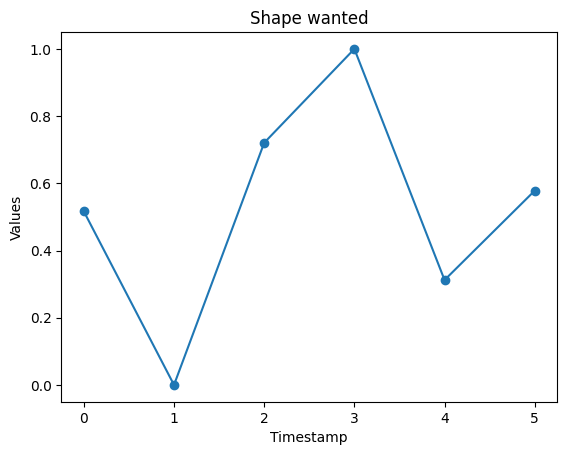

In [4]:
# Initialize finder with data and shape targets
find = finder_multi_static(data,cov,shape,input_cov=input_cov)

# Visualize the Input Pattern
shape.plot()

In [5]:
# First Pattern Matching (Unweighted)
find.find_patterns(
    min_d=1.45,        # Minimum DTW similarity
    mode='include',    # Include the covariates in the pattern search
    select=True,       # No overlapping window allowed
    metric='dtw',      # Distance metric: Dynamic Time Warping
    min_mat=5,         # Minimum number of matched patterns
    weight=[1,1,1]     # The shape and covariate distances are included equally (each weight are 1)
)

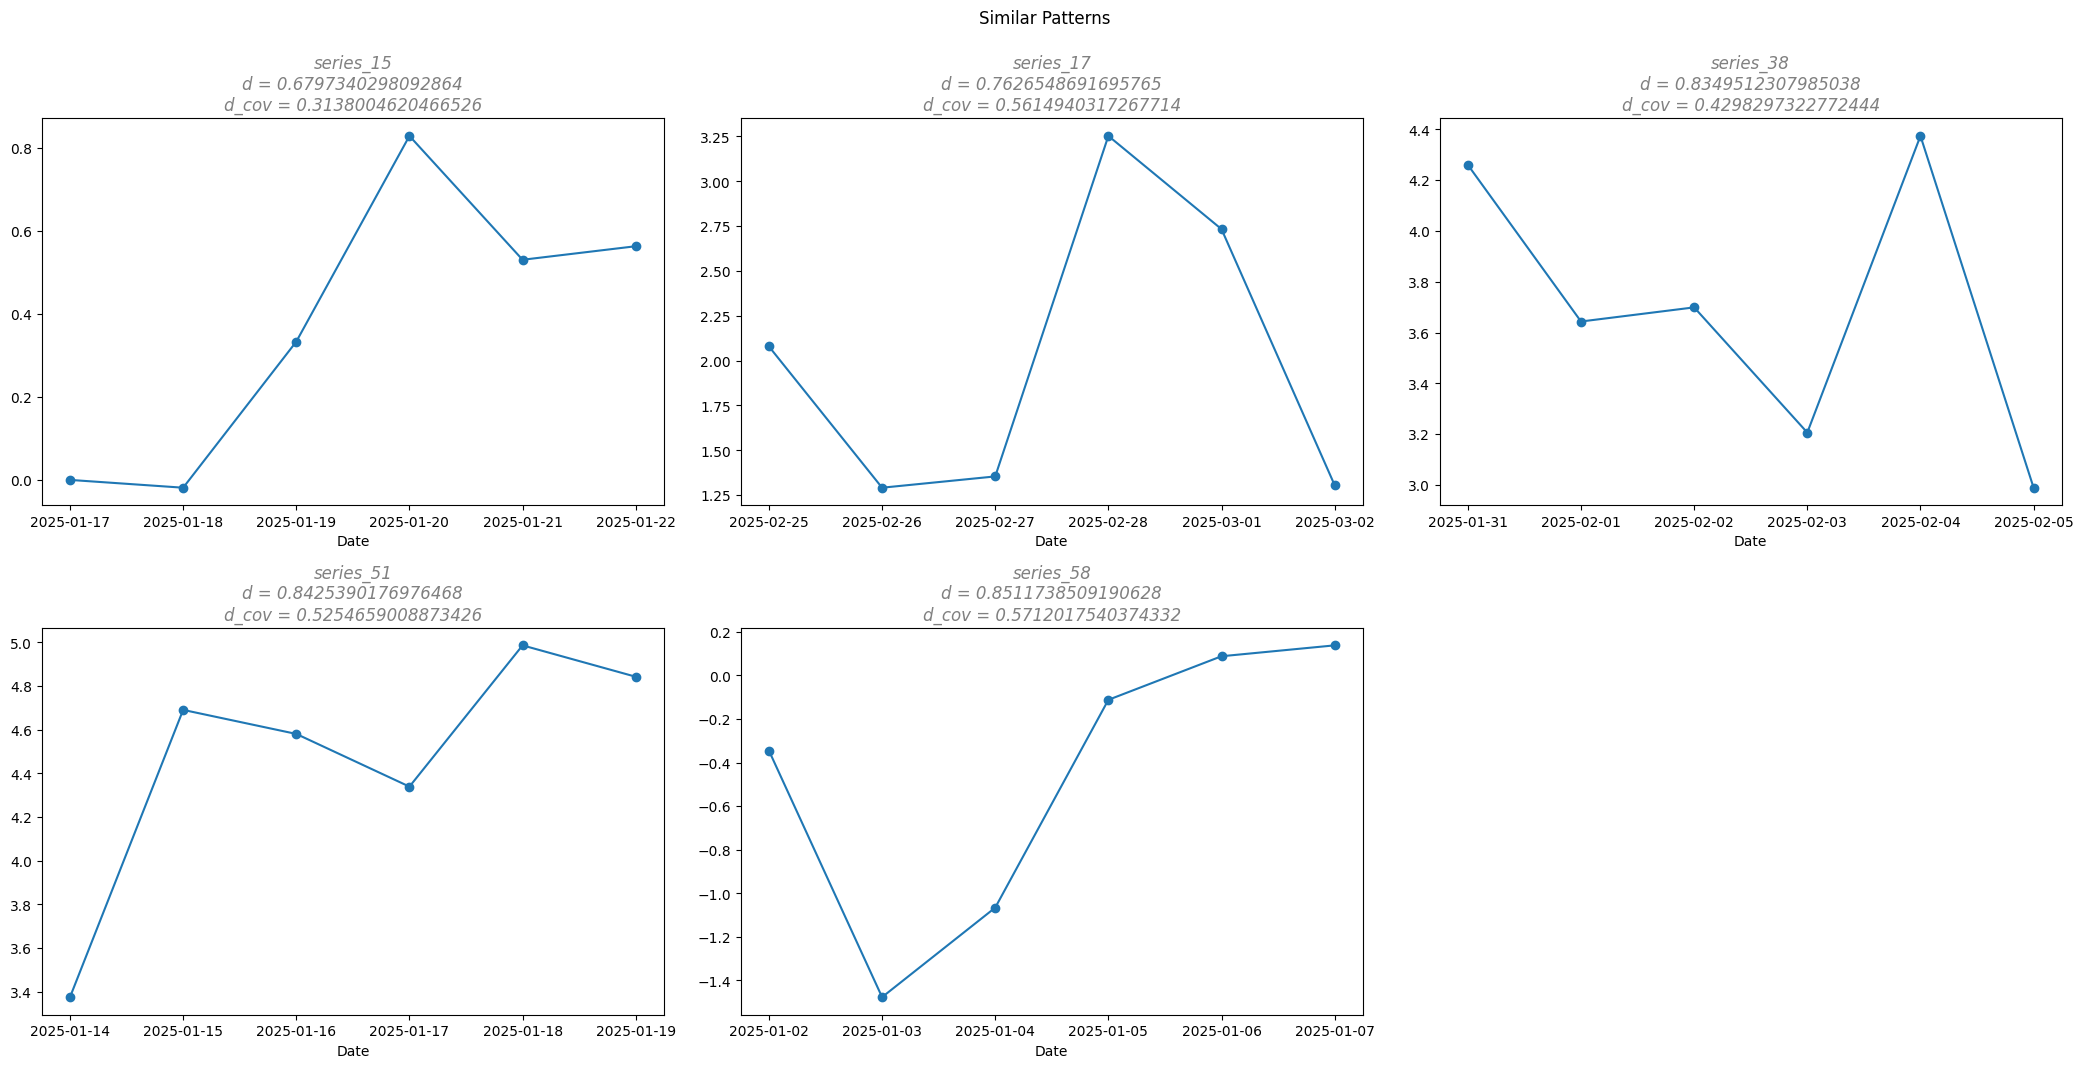

In [6]:
# Plot all matched sequences in data
find.plot_sequences(how='total')  

The model found similar patterns in the historical data:
- Most of the similar patterns are not exactly the same shape (distance>0.6) 
- But quite close in term of covariates (distance_cov<0.6)

In [7]:
 # Make prediction for next 3 steps (with covariate equal weighting)
pred_equal = find.predict(horizon=3,mode='classical')

We change the weights to see if the model lead to different outcomes. We look now only for similar patterns of the main variable without inclusion of the covariates in the process. 

In [8]:
# Second Pattern Matching (without covariates)
find.find_patterns(
    min_d=0.2,        # Minimum DTW similarity
    mode='exclude',    # Include the covariates in the pattern search
    select=True,       # No overlapping window allowed
    metric='dtw',      # Distance metric: Dynamic Time Warping
    min_mat=5          # Minimum number of matched patterns
)

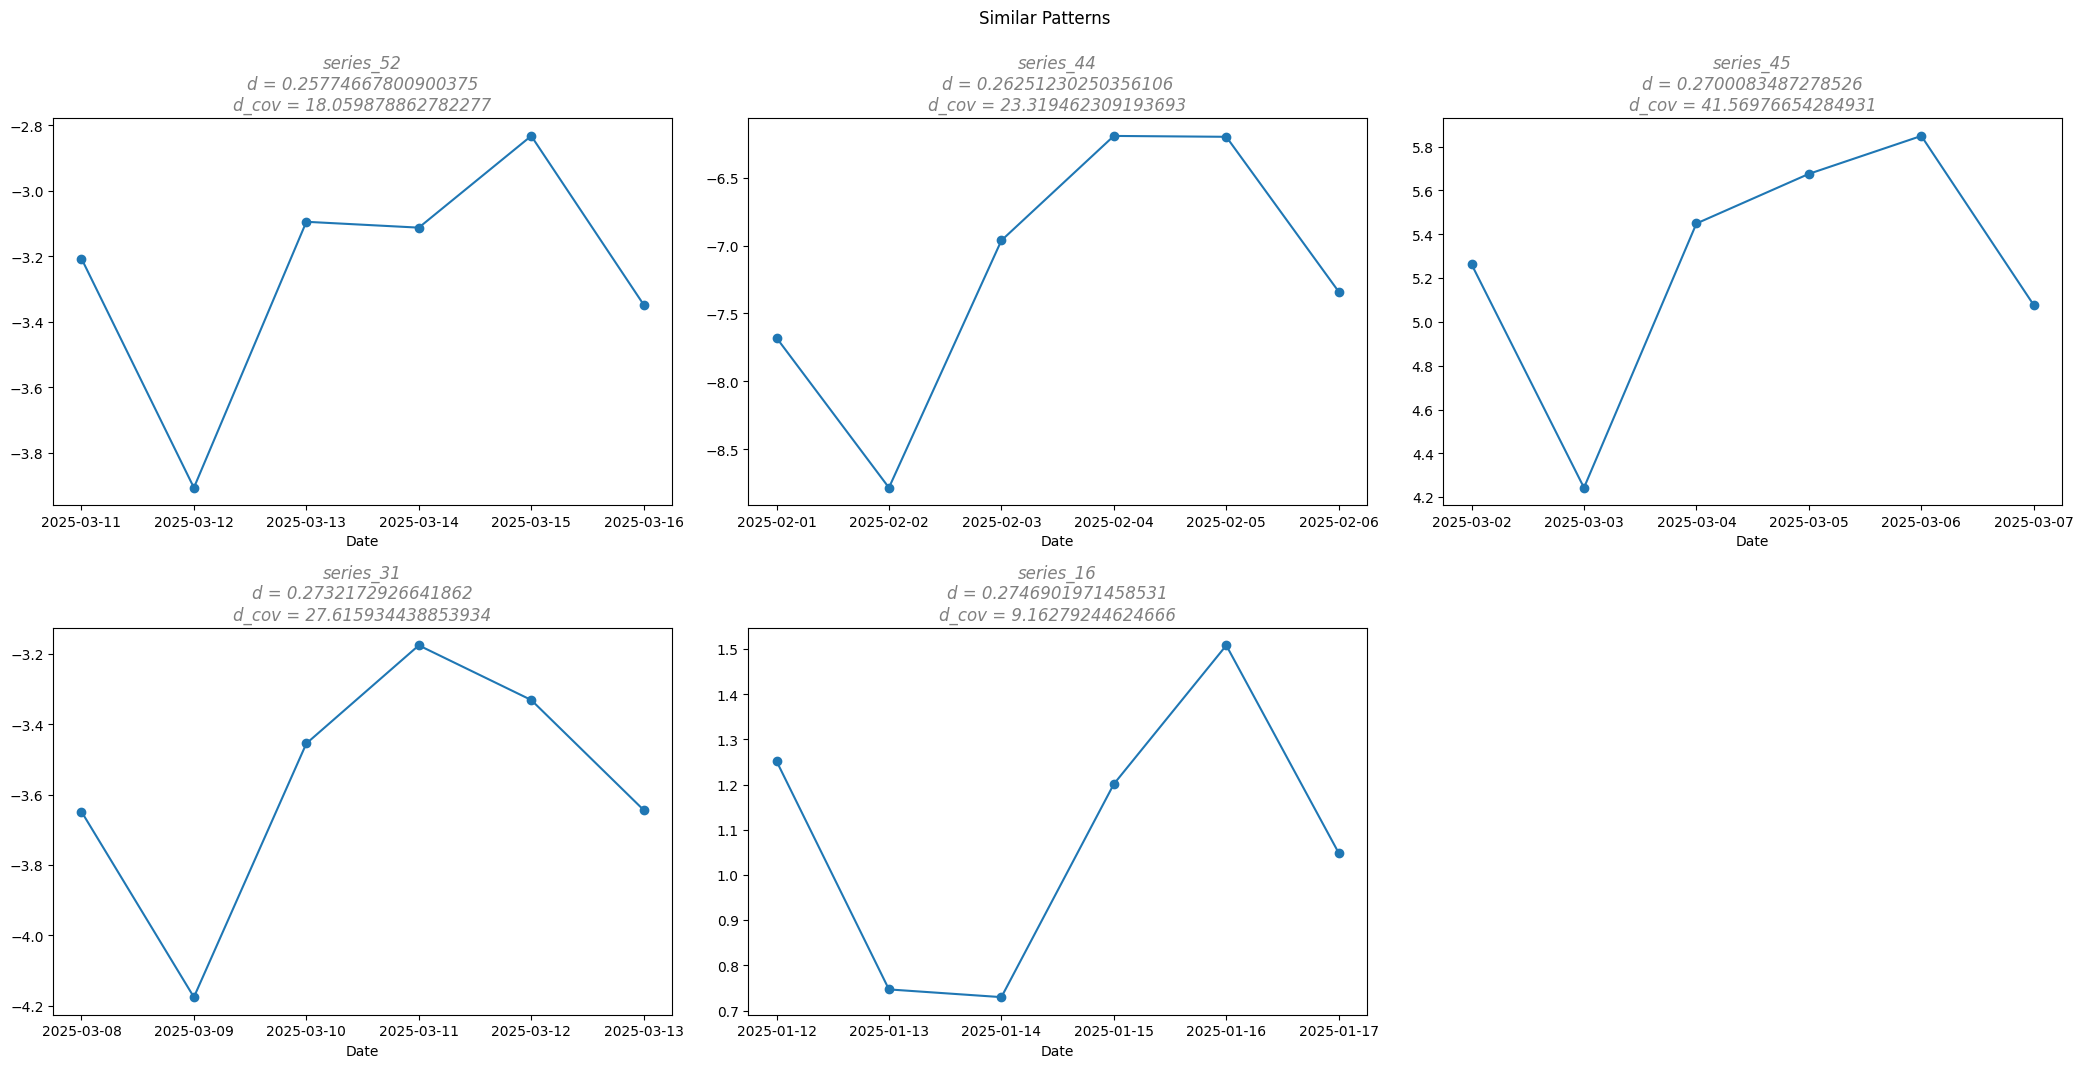

In [9]:
# Visualize sequences with weights applied
find.plot_sequences(how='total')

We see now two differences for the outcome:

- The shapes are now way closer to the input shape.
- However, the covariate distance are really high, as they are not included in the distance metric (weight=0). 


In [10]:
# Make new prediction without covariates in the distance metric
pred_shape = find.predict(horizon=3,mode='classical')  

The covariates can be also included in the scenario creation process: 
1. In the clustering process (before clustering, mode='b-cluster')
2. In the weight of the sequences of the selected scenario (after clustering, mode='a-cluster')

In [11]:
# Make new prediction with both modes
pred_before = find.predict(horizon=3,mode='b-cluster') 

pred_after = find.predict(horizon=3,mode='a-cluster') 

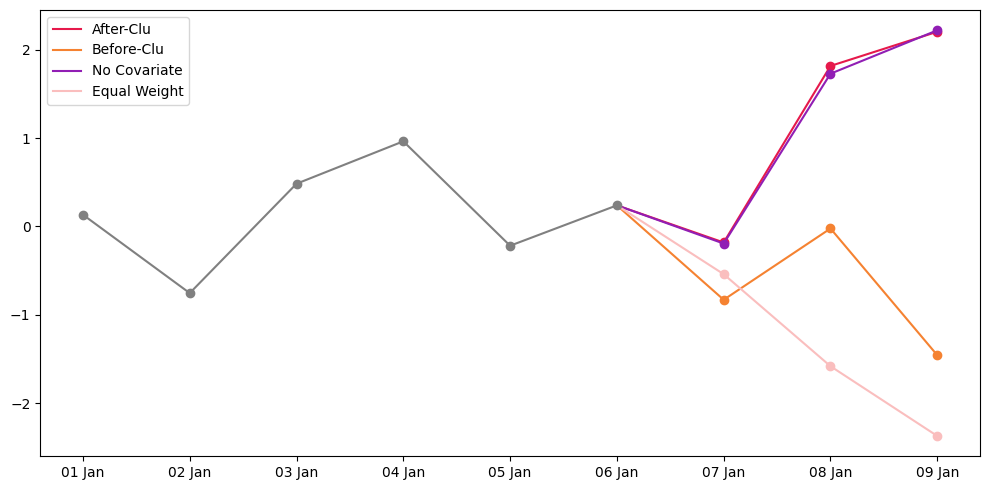

In [12]:
# Plot the different predictions

# Rescale Predictions to Original Scale
# The predictions (between 0 and 1) are rescaled using the input shape's min and max
pred_equal = pred_equal * (inp_1.max() - inp_1.min()) + inp_1.min()
pred_shape = pred_shape * (inp_1.max() - inp_1.min()) + inp_1.min()
pred_before = pred_before * (inp_1.max() - inp_1.min()) + inp_1.min()
pred_after = pred_after * (inp_1.max() - inp_1.min()) + inp_1.min()

# Convert Predictions to Series and Set Date Index 
# The forecast horizon is 3 days, starting right after the input ends (input ends on Jan 6)
pred_equal = pd.Series(pred_equal)
pred_equal.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

pred_shape = pd.Series(pred_shape)
pred_shape.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

pred_before = pd.Series(pred_before)
pred_before.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

pred_after = pd.Series(pred_after)
pred_after.index = pd.date_range(start='2025-01-07', periods=3, freq='D')

# Add Last Input Point to Each Prediction Series for Plotting Continuity
pred_after_l = pd.concat([inp_1.iloc[-1:], pred_after])
pred_before_l = pd.concat([inp_1.iloc[-1:], pred_before])
pred_shape_l = pd.concat([inp_1.iloc[-1:], pred_shape])
pred_equal_l = pd.concat([inp_1.iloc[-1:], pred_equal])

# Plot Input and Forecasts (Weighted vs Not Weighted)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pred_after, marker='o', color='#e6194b',linewidth=0)
ax.plot(pred_after_l, color='#e6194b', label='After-Clu')
ax.plot(pred_before, marker='o', color='#f58231',linewidth=0)
ax.plot(pred_before_l, color='#f58231', label='Before-Clu')
ax.plot(pred_shape, marker='o', color='#911eb4',linewidth=0)
ax.plot(pred_shape_l, color='#911eb4', label='No Covariate')
ax.plot(pred_equal, marker='o', color='#fabebe',linewidth=0)
ax.plot(pred_equal_l, color='#fabebe', label='Equal Weight')
ax.plot(inp_1, marker='o', color='grey')
ax.xaxis.set_major_formatter(DateFormatter('%d %b'))
plt.legend()
plt.tight_layout()
plt.show()